# Task 1

## P1 

In [55]:
import math
import numpy as np 
    
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [56]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [57]:
from functools import reduce

def interaction(x, y, theta, Rf, L):
    """
    Function to calculate the orientation at the next time step.
    
    Parameters
    ==========
    x, y : Positions.
    theta : Orientations.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    s : Discrete steps.
    """
    
    N = np.size(x)

    theta_next = np.zeros(N)
    
    # Preselect what particles are closer than Rf to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + Rf > L / 2)[0], 
            np.where(y - Rf < - L / 2)[0],
            np.where(x + Rf > L / 2)[0],
            np.where(x - Rf > - L / 2)[0]
        )
    )

    for j in range(N):
        # Check if replicas are needed to find the nearest neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            nn = []
            for nr in range(9):
                dist2 = (x - xr[nr]) ** 2 + (y - yr[nr]) ** 2 
                nn = np.union1d(nn, np.where(dist2 <= Rf ** 2)[0])
        else:
            dist2 = (x - x[j]) ** 2 + (y - y[j]) ** 2 
            nn = np.where(dist2 <= Rf ** 2)[0]
        
        # The list of nearest neighbours is set.
        nn = nn.astype(int)
        
        # Circular average.
        av_sin_theta = np.mean(np.sin(theta[nn]))
        av_cos_theta = np.mean(np.cos(theta[nn]))
        
        theta_next[j] = np.arctan2(av_sin_theta, av_cos_theta)
                   
    return theta_next

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def area_polygon(vertices):
    """
    Function to calculate the area of a Voronoi region given its vertices.
    
    Parameters
    ==========
    vertices : Coordinates (array, 2 dimensional).
    """    
    
    N, dim = vertices.shape
    
    # dim is 2.
    # Vertices are listed consecutively.
    
    A = 0
    
    for i in range(N-1):
        # Below is the formula of the area of a triangle given the vertices.
        A += np.abs(
            vertices[- 1, 0] * (vertices[i, 1] - vertices[i + 1, 1]) +
            vertices[i, 0] * (vertices[i + 1, 1] - vertices[- 1, 1]) +
            vertices[i + 1, 0] * (vertices[- 1, 1] - vertices[i, 1])
        )
    
    A *= 0.5
    
    return A


def global_clustering(x, y, Rf, L):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    x, y : Positions.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)
    
    # Use the replicas of all points to calculate Voronoi for 
    # a more precise estimate.
    points = np.zeros([9 * N, 2])

    for i in range(3):
        for j in range(3):
            s = 3 * i + j
            points[s * N:(s + 1) * N, 0] = x + (j - 1) * L
            points[s * N:(s + 1) * N, 1] = y + (i - 1) * L

    # The format of points is the one needed by Voronoi.
    # points[:, 0] contains the x coordinates
    # points[:, 1] contains the y coordinates
   
    vor = Voronoi(points)     
    '''
    vertices = vor.vertices  # Voronoi vertices.
    regions = vor.regions  # Region list. 
    # regions[i]: list of the vertices indices for region i.
    # If -1 is listed: the region is open (includes point at infinity).
    point_region = vor.point_region  # Region associated to input point.
    '''
   
    # Consider only regions of original set of points (no replicas).
    list_regions = vor.point_region[4 * N:5 * N]
    
    c = 0

    for i in list_regions:
        indices = vor.regions[i]
        # print(f'indices = {indices}')
        if len(indices) > 0:
            if np.size(np.where(np.array(indices) == -1)[0]) == 0:
                # Region is finite.
                # Calculate area.
                A = area_polygon(vor.vertices[indices,:])
                if A < np.pi * Rf ** 2:
                    c += 1
                    
    c = c / N
                   
    return c

In [ ]:
def global_alignment(theta):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    theta : Orientations.
    """
    
    N = np.size(theta)
    
    global_direction_x = np.sum(np.sin(theta))
    global_direction_y = np.sum(np.cos(theta))
        
    psi = np.sqrt(global_direction_x ** 2 + global_direction_y ** 2) / N
    
                   
    return psi

In [58]:
N_part = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 2  # Flocking radius.
eta = 0.01  # Noise.  Try values: 0.01, 0.3, 1.0, 2 * np.pi
dt = 1  # Time step.


# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]


In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *


step = 0
t_tot = 6000

config_x = []
config_y = []
config_theta = []

psi = np.zeros(t_tot+1) 
c = np.zeros(t_tot+1)

while step <= t_tot: 
    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    
    # Calculate next theta from the rule.
    dtheta = eta * (np.random.rand(N_part) - 0.5) * dt
    ntheta = interaction(x, y, theta, Rf, L) + dtheta
    nx = x + v * np.cos(ntheta)
    ny = y + v * np.sin(ntheta)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if(step == 0 or step == 2000 or step == 4000 or step == 6000):
        config_x.append(nx)
        config_y.append(ny)
        config_theta.append(ntheta)

    step += 1
    if step % 100 == 0:
        print(step)
        
    x[:] = nx[:]
    y[:] = ny[:]
    theta[:] = ntheta[:]  




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

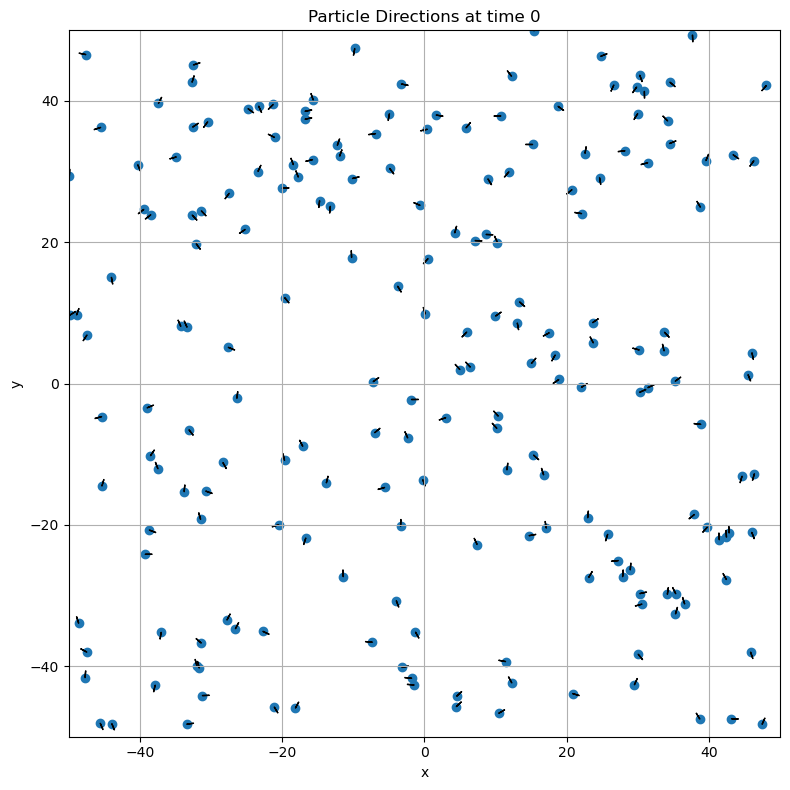

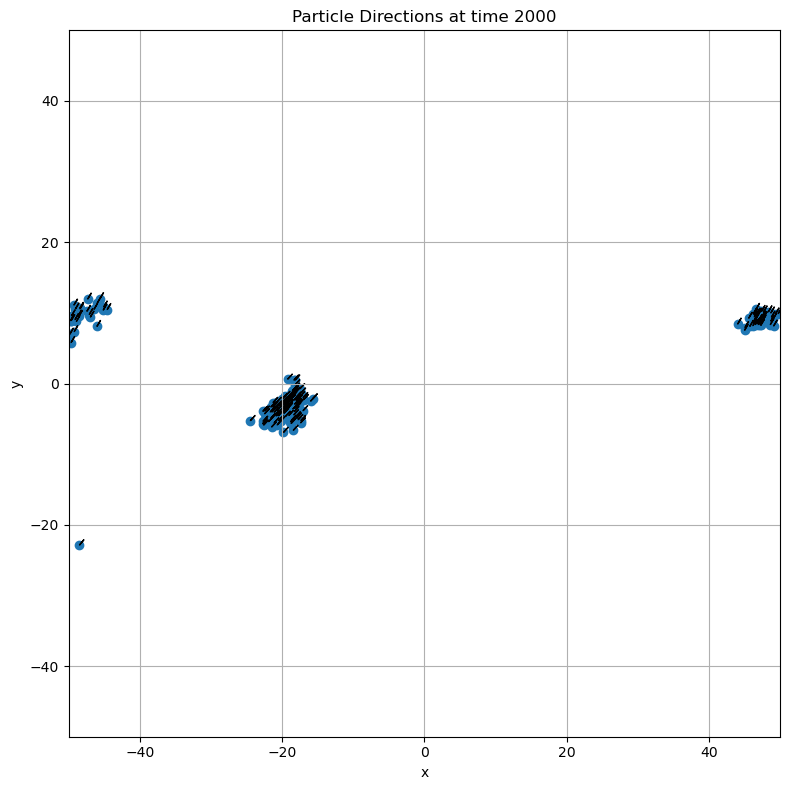

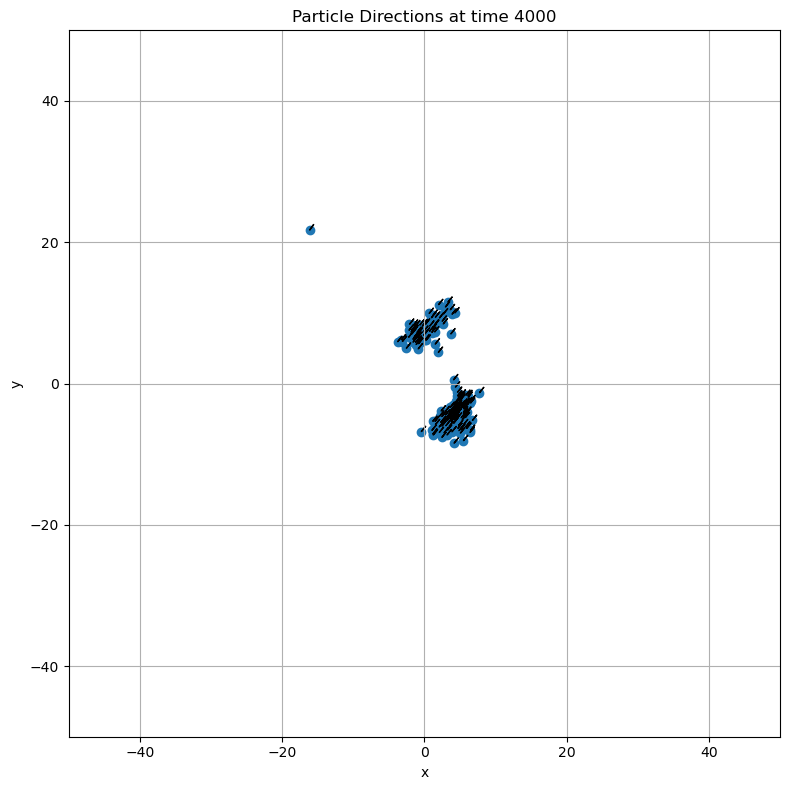

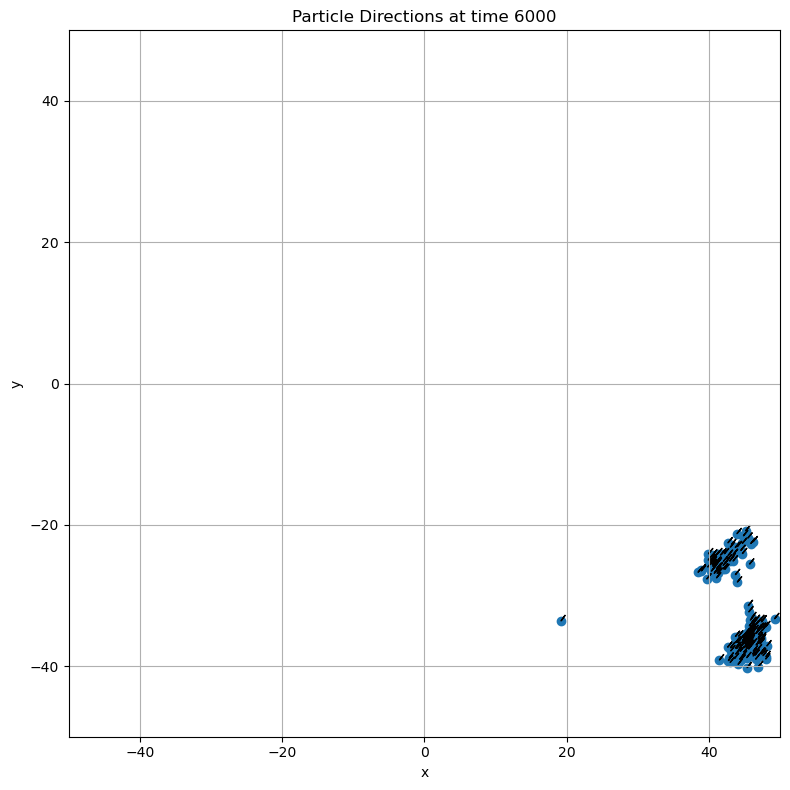

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Prepare time steps corresponding to snapshots
time_steps = [0, 2000, 4000, 6000]

# Plot arrows representing particle directions at each snapshot
for i, time in enumerate(time_steps):
    plt.figure(figsize=(8, 8))
    x_positions = config_x[i]
    y_positions = config_y[i]
    angles = config_theta[i]

    u = np.cos(angles)
    v = np.sin(angles)

    plt.scatter(x_positions, y_positions )
    for j in range(len(x_positions)):
        plt.arrow(x_positions[j], y_positions[j], u[j], v[j] )
    plt.title(f'Particle Directions at time {time}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.xlim([-L/2,L/2])
    plt.ylim([-L/2,L/2])
    plt.tight_layout()
    plt.show()


## P2 

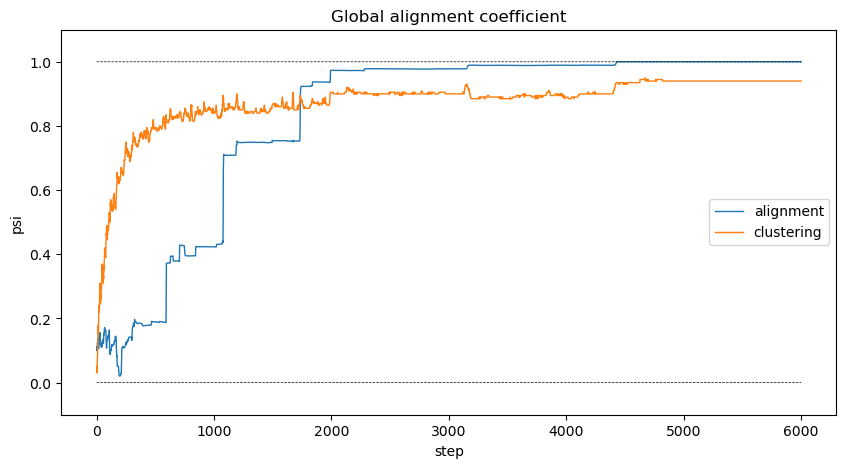

In [70]:

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='alignment')
plt.plot(c, '-', linewidth=1, label='clustering')
plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)
plt.title('Global alignment coefficient')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi')
plt.ylim([-0.1, 1.1])
plt.show()

# Task 2

## P3 

In [78]:
N_part = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 2  # Flocking radius.
eta1 = 0.01  
eta2 = 0.3
dt = 1  # Time step.

x = (np.random.rand(N_part) - 0.5) * L  
y = (np.random.rand(N_part) - 0.5) * L  

# Random orientation.
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  

In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *


step = 0
t_tot = 6000

config_x = []
config_y = []
config_theta = []

psi = np.zeros(t_tot+1) 
c = np.zeros(t_tot+1)

while step <= t_tot: 
    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    
    dtheta = np.zeros(N_part)
    half_N = N_part // 2
    dtheta[:half_N] = eta1 * (np.random.rand(half_N) - 0.5) * dt
    dtheta[half_N:] = eta2 * (np.random.rand(N_part-half_N) - 0.5) * dt

    ntheta = interaction(x, y, theta, Rf, L) + dtheta
    nx = x + v * np.cos(ntheta)
    ny = y + v * np.sin(ntheta)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if(step == 0 or step == 2000 or step == 4000 or step == 6000):
        config_x.append(nx)
        config_y.append(ny)
        config_theta.append(ntheta)

    step += 1
    if step % 100 == 0:
        print(step)
        
    x[:] = nx[:]
    y[:] = ny[:]
    theta[:] = ntheta[:]  




100
200
300


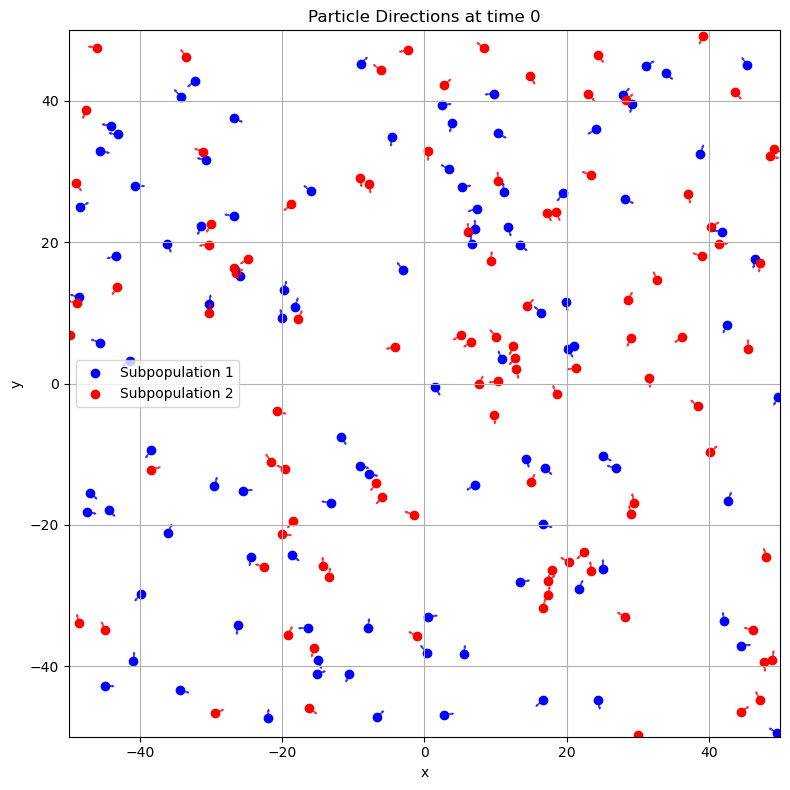

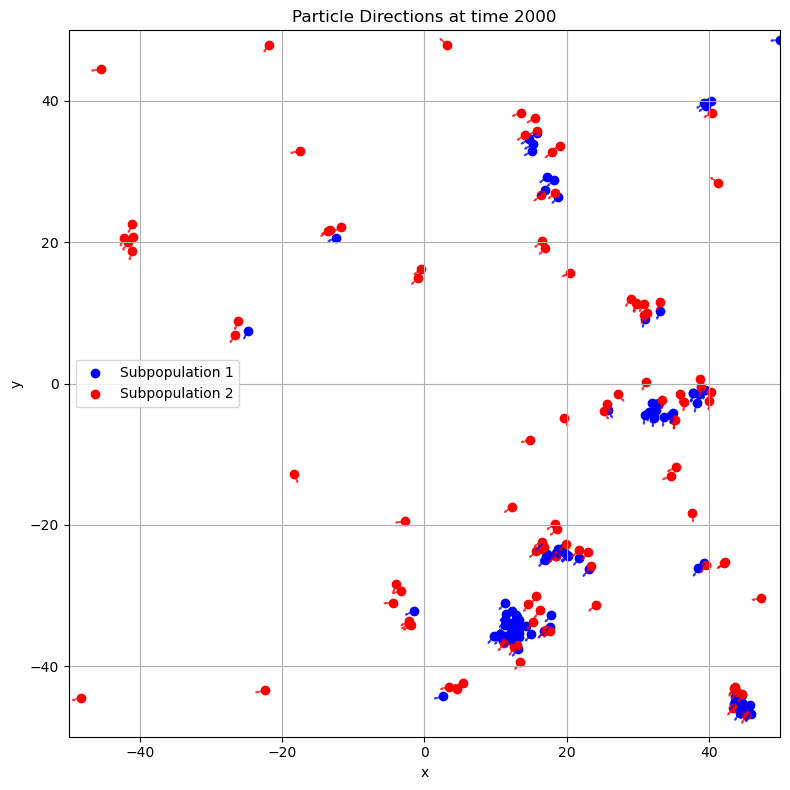

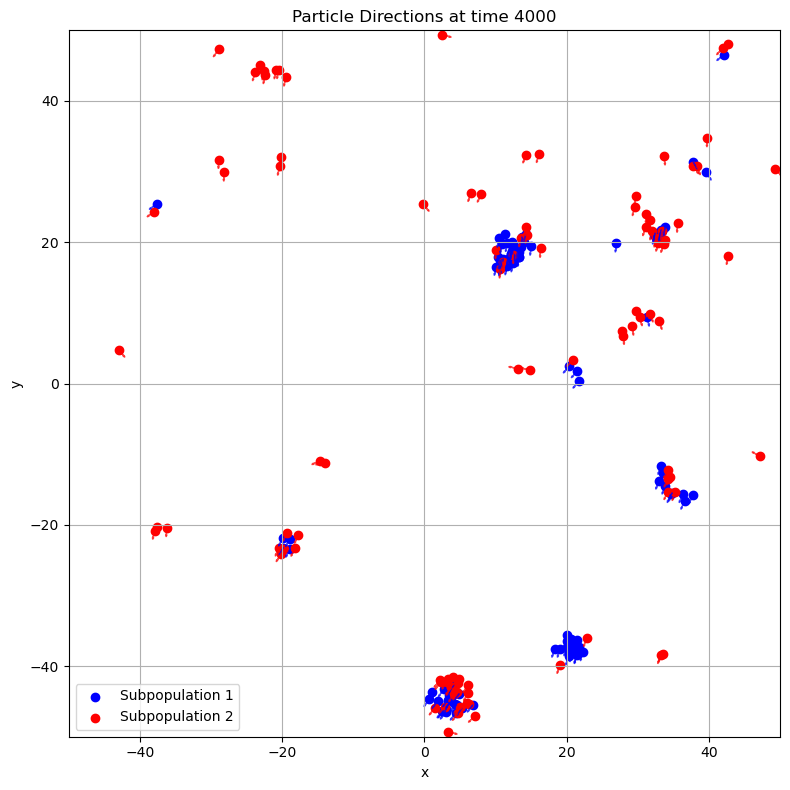

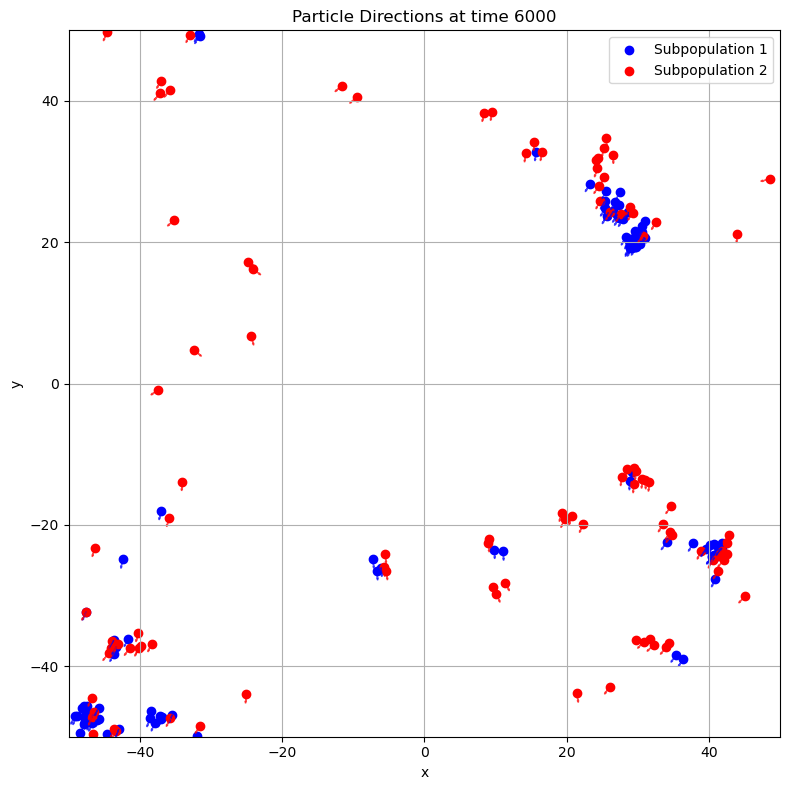

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume time_steps, config_x, config_y, config_theta are already defined
time_steps = [0, 2000, 4000, 6000]
N_half = N_part // 2  

for i, time in enumerate(time_steps):
    plt.figure(figsize=(8, 8))
    
    x_positions = config_x[i]
    y_positions = config_y[i]
    angles = config_theta[i]

    x_positions_1, x_positions_2 = x_positions[:N_half], x_positions[N_half:]
    y_positions_1, y_positions_2 = y_positions[:N_half], y_positions[N_half:]
    angles_1, angles_2 = angles[:N_half], angles[N_half:]

    u1, v1 = np.cos(angles_1), np.sin(angles_1)
    u2, v2 = np.cos(angles_2), np.sin(angles_2)

    plt.scatter(x_positions_1, y_positions_1, color='blue', label='Subpopulation 1')
    plt.scatter(x_positions_2, y_positions_2, color='red', label='Subpopulation 2')

    for j in range(len(x_positions_1)):
        plt.arrow(x_positions_1[j], y_positions_1[j], u1[j], v1[j], color='blue', head_width=0.2, alpha=0.7)
    for j in range(len(x_positions_2)):
        plt.arrow(x_positions_2[j], y_positions_2[j], u2[j], v2[j], color='red', head_width=0.2, alpha=0.7)

    plt.title(f'Particle Directions at time {time}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.xlim([-L / 2, L / 2])
    plt.ylim([-L / 2, L / 2])
    plt.legend()
    plt.tight_layout()
    plt.show()


## P4

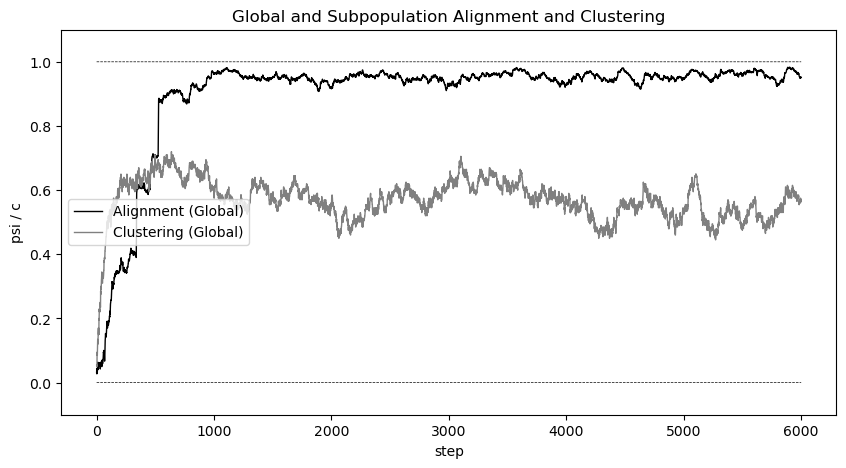

In [ ]:
from matplotlib import pyplot as plt

N_half = N_part // 2  


plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='Alignment (Global)')
plt.plot(c, '-', linewidth=1, label='Clustering (Global)')

plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)

plt.title('Global and Subpopulation Alignment and Clustering')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi / c')
plt.ylim([-0.1, 1.1])
plt.show()
